# Sine Function variational_circuit


##  Challenge
The goal of this subtask is to develop your own
model and use it to learn the sine function on the interval [0, 2π]. Discretize
the interval with a suitable number of points (of your choice) and use the
values of the sine function at these discretization points as labels.
Implement a Quantum Machine Learning model which reproduces the
values of the sine function.

The additional challenge will be to predict four additional functions, bringing the total to five functions.

1. A regular sine function.
2. A positive linear function.
3. A cubic function.

### Imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

/Users/ricardosantiago/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Model creation

We define a layer function.

This function applies a series of quantum gates to a qubit on wire 0:

- qml.RZ(angle, wires=0) applies a rotation around the Z-axis by angle.
- qml.RX(angle, wires=0) applies a rotation around the X-axis by angle.
- qml.RY(angle, wires=0) applies a rotation around the Y-axis by angle

We start up the quantum device and then define a circuit function that does the following:
- qml.Hadamard(wires=0) applies a Hadamard gate to the qubit on wire 0, creating a superposition state.
- The for loop iterates over the weights (which is expected to be a list of weight pairs) and applies the layer function to each pair of weights and the input x.
- qml.expval(qml.PauliZ(0)) measures the expectation value of the Pauli-Z operator on the qubit at wire 0.

Finally we define the prediction function:
- Calls the circuit function with weights and x as arguments, getting the expectation value of the Pauli-Z operator.
- Adds a bias term to the result, effectively shifting the output by the bias value.

In [2]:
def layer(weights,x):
    qml.RZ(x + weights[0],wires=0)
    qml.RX(weights[1],wires=0)
    qml.RY(weights[2],wires=0)

dev = qml.device("default.qubit")
@qml.qnode(dev)
def circuit(weights, x):
    qml.Hadamard(wires=0)

    for layer_weights in weights:
        layer(layer_weights,x)
    
    return qml.expval(qml.PauliZ(0))

def variational_circuit(weights, bias, x):
    return circuit(weights, x) + bias

We define a cost function and use the Root Mean Squared Error (RMSE) metric for cost comparison. 

RMSE measures the difference between predicted and actual values, helping us evaluate and improve model accuracy.

In [3]:
def cost(weights, bias, X, Y):
    predictions = [variational_circuit(weights, bias, x) for x in X]
    return rmse(Y, predictions)

def rmse(labels, predictions):
    return np.sqrt(np.mean((labels - qml.math.stack(predictions)) ** 2))

### Data preparation

The following numerical functions will be the ones we will predict.

1. A regular sine function.
2. A positive linear function.
3. A cubic function.

In [4]:
def sine(X):
    return np.sin(X)

def linear(X):
    return 3 * X -5

def cubic(X):
    return X**3
functions = [sine,linear,cubic]

### Preprocessing
- The data_normalization function converts data from its original scale to a range between -1 and 1.
- The denormalize function converts data from the range [-1, 1] back to its original scale.

In [5]:
def data_denormalization(Y,min_value,max_value):
    return min_value + (Y + 1) * (max_value - min_value) / 2

def data_normalization(Y,min_value,max_value):
    return  -1 + 2 * (Y - min_value) / (max_value - min_value)

For each function we apply the normalization

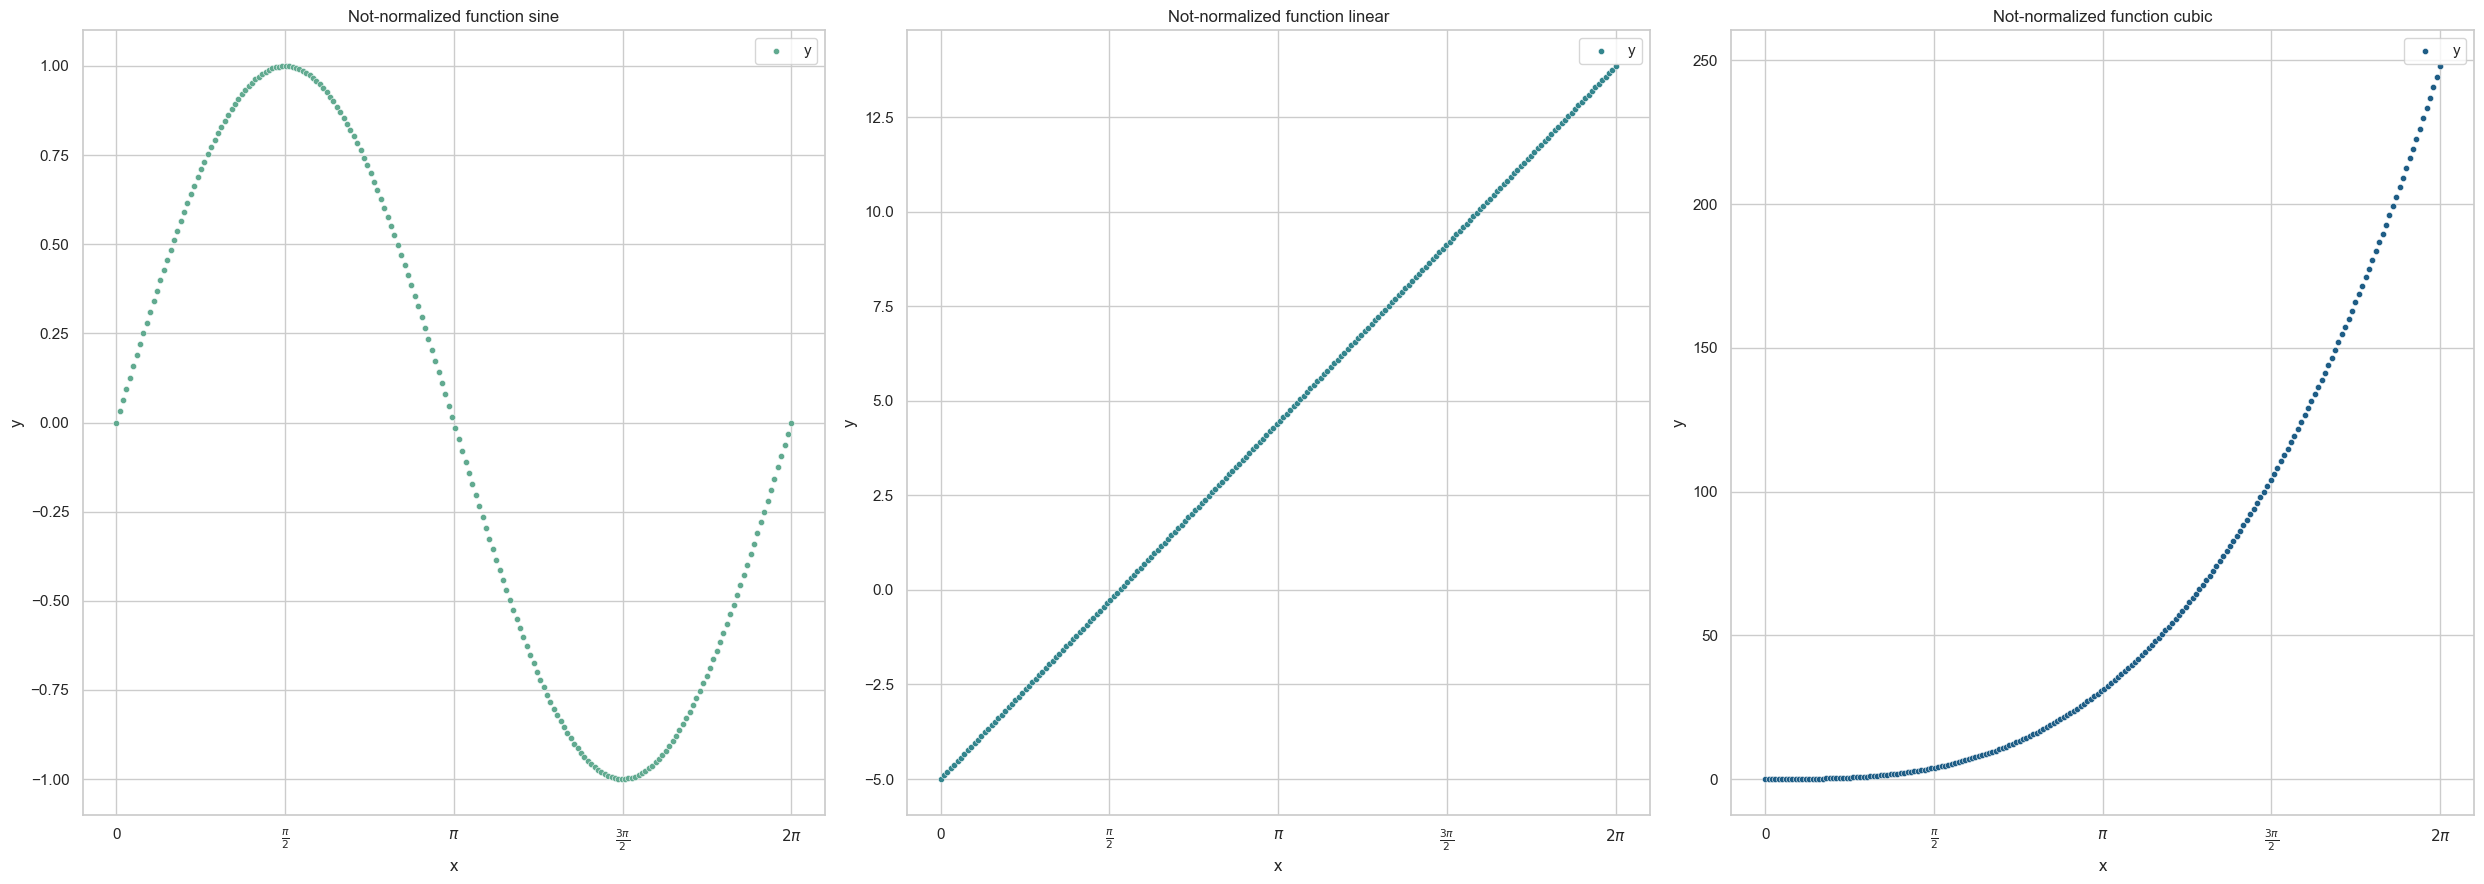

In [6]:
sns.set(style='whitegrid')
palette = sns.color_palette("crest", n_colors=len(functions))

a, b = 0, 2 * np.pi
n_points = [200, 200, 200]
Xs = [np.linspace(a, b, n_p) for n_p in n_points]

fig, axs = plt.subplots(1, 3, figsize=(25, 9))

minmax_values = []
Ys = []
names=["sine","linear","cubic"]

for i, func in enumerate(functions):
    X = Xs[i]
    Y = func(X)
    sns.scatterplot(x=X, y=Y, s=20, ax=axs[i], label='y', color=palette[i], edgecolor='w')
    axs[i].set_title(f'Not-normalized function {names[i]}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_xticks(np.linspace(0, 2 * np.pi, 5))
    axs[i].set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
    min_value, max_value = np.min(Y), np.max(Y)
    Ys.append(data_normalization(Y, min_value, max_value))
    minmax_values.append((min_value, max_value))

plt.tight_layout()
plt.show()


### Data splitting

We define the training and test sets.

The training set will comprise a portion of the total dataset.

This division will be illustrated in a graph, where the blue dots represent the training set and the orange dots represent the test set.

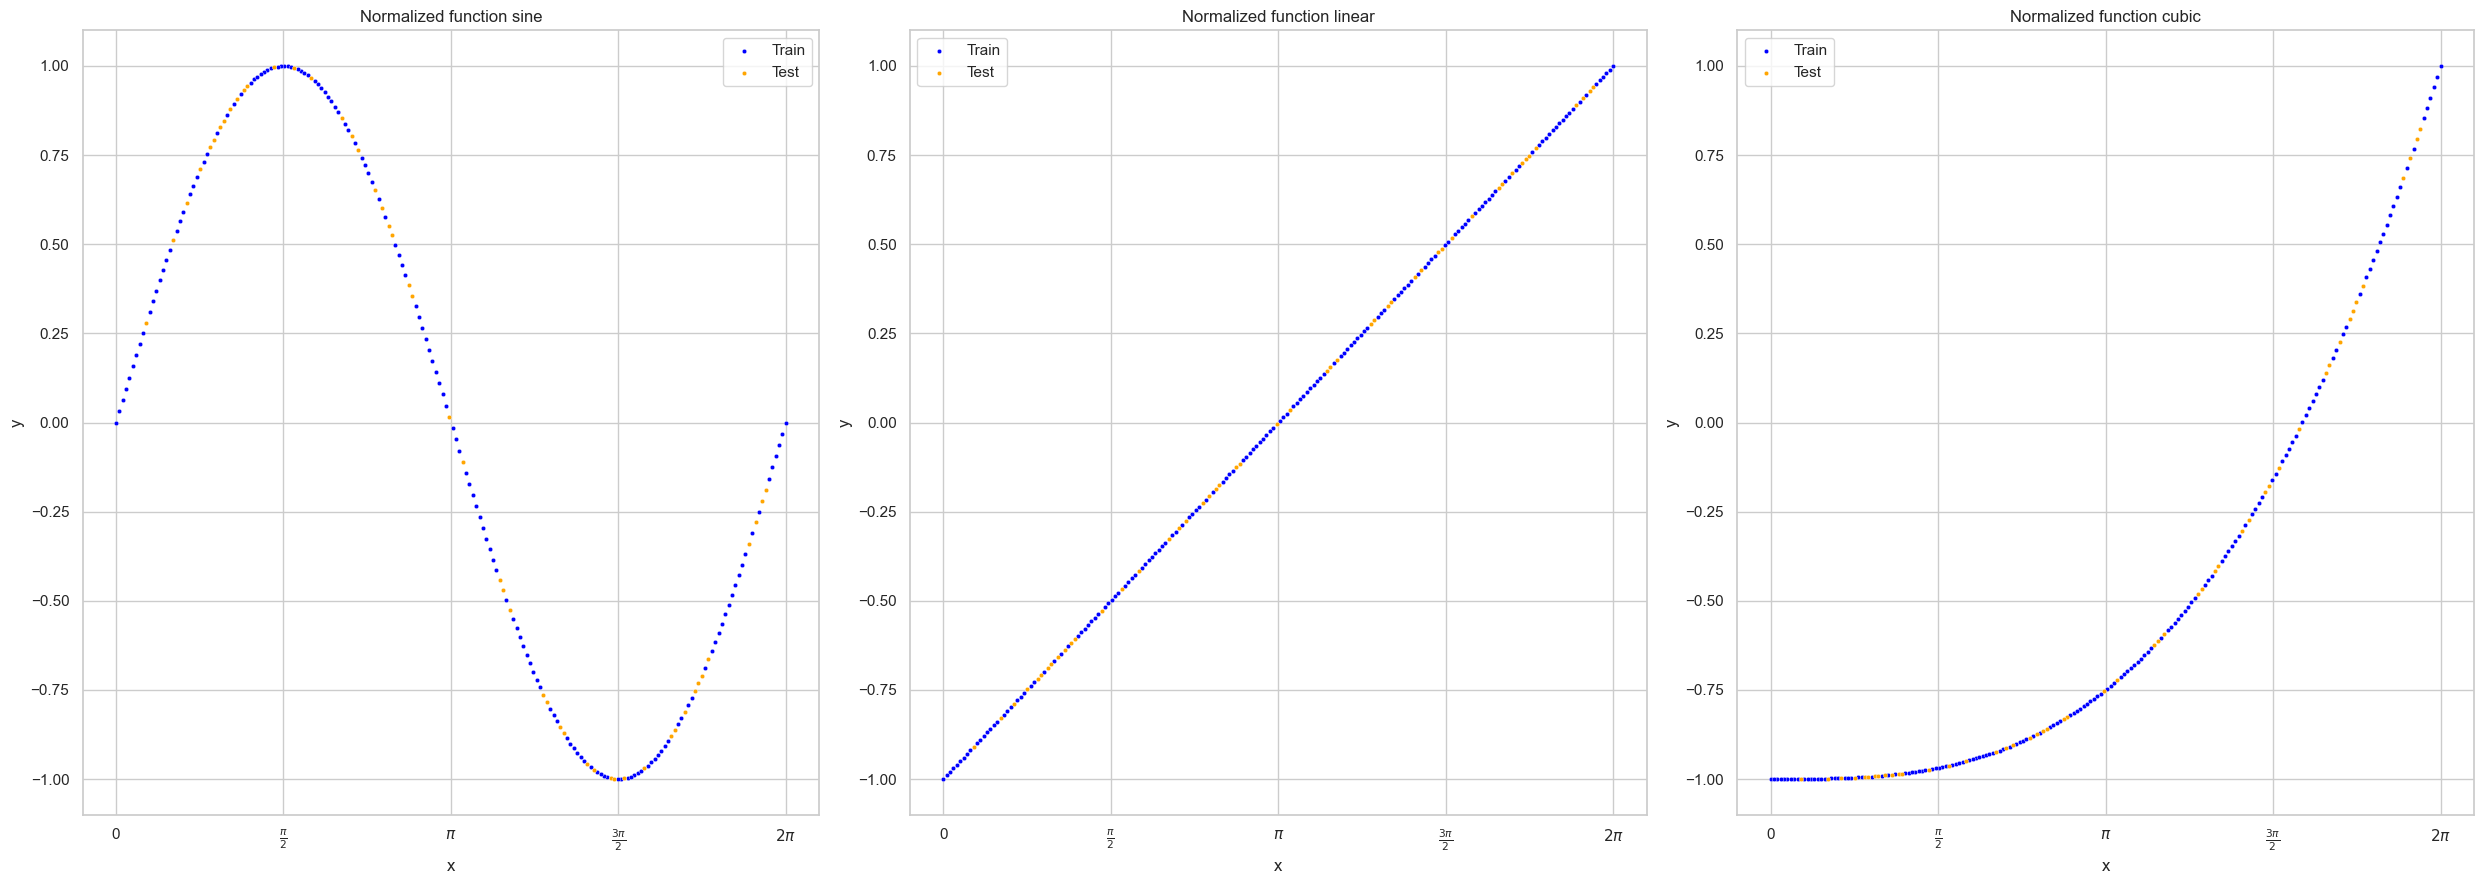

In [7]:
np.random.seed(0)
nums_train = [int(0.75 * n_p) for n_p in n_points]

index_100 = np.random.permutation(range(n_points[0]))
indexes = [index_100] * 3

Ys_train = []
Ys_test = []

Xs_train = [ Xs[i][indexes[i][:num_train]] for i,num_train in enumerate(nums_train) ]
Xs_test = [ Xs[i][indexes[i][num_train:]] for i,num_train in enumerate(nums_train) ]
names=["sine","linear","cubic"]

fig, axs = plt.subplots(1, 3, figsize=(25, 9)) 
for i,Y in enumerate(Ys):
    num_train = nums_train[i]
    X_train = Xs_train[i]
    X_test = Xs_test[i]
    index = indexes[i]
    
    Y_train = Y[index[:num_train]]
    Y_test = Y[index[num_train:]]
    
    sns.scatterplot(x=X_train, y=Y_train, s=10, label='Train', ax=axs[i], color='blue')
    sns.scatterplot(x=X_test, y=Y_test, s=10, label='Test', ax=axs[i], color='orange')
    axs[i].set_title(f'Normalized function {names[i]}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].grid(True)
    
    radian_ticks = np.linspace(0, 2 * np.pi, 5) 
    radian_labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
    axs[i].set_xticks(radian_ticks)
    axs[i].set_xticklabels(radian_labels)

    Ys_train.append(Y_train)
    Ys_test.append(Y_test)

plt.tight_layout()
plt.show()

### Training function

We define an training function

This function performs optimization using an iterative approach, updates model parameters (weights and biases) based on a cost function, and tracks performance on both training and test datasets. 

The optimizer is used to adjust the parameters, and the performance is evaluated using RMSE (Root Mean Squared Error).

In [8]:
def train(inits, X_train, Y_train, X_test, Y_test, optimizer, opt_itrs=100):
    weights, bias = inits
    best_weights, best_bias, best_itr, best_cost = None, None, None, float('inf')
    costs = []

    for i in range(opt_itrs):
        weights, bias = optimizer.step(cost, weights, bias, X=X_train, Y=Y_train)
        current_cost = cost(weights, bias, X_train, Y_train)
        
        if current_cost < best_cost:
            best_weights, best_bias, best_itr, best_cost = weights, bias, i + 1, current_cost
        
        costs.append(current_cost)
        
        predictions_test = [variational_circuit(weights, bias, x) for x in X_test]
        acc_test = rmse(Y_test, predictions_test)
        print(f"Iteration: {i+1:4d} | train_RMSE: {current_cost:0.7f} | test_RMSE: {acc_test:0.7f}")
    
    return best_weights, best_bias, best_itr, best_cost, costs


We define the evaluation function, which returns an analysis based on a given set of parameters.

For each numerical function:

The RMSE (Root Mean Squared Error) is computed and returned. The function is kept normalized to provide a relative basis for comparing this metric.

In [9]:

def eval(params):
    predictions = []
    normalized_predictions = []
    names=["sine","linear","cubic"]
    for i, param in enumerate(params):
        function_predictions = []
        X = Xs_test[i]
        for x in X:
            prediction=variational_circuit(param[0],param[1],x)
            function_predictions.append(prediction)

        min,max = minmax_values[i]
        predictions.append(data_denormalization(qml.math.stack(function_predictions),min,max))
        normalized_predictions.append(qml.math.stack(function_predictions))

    fig, axs = plt.subplots(1, len(predictions), figsize=(25, 7)) 
    for i,f_predictions in enumerate(predictions):
        X_test = Xs_test[i]    
        min,max = minmax_values[i]
        Y_test = data_denormalization(Ys_test[i],min,max)
        normalized_Y_test = Ys_test[i]
        axs[i].scatter(X_test, Y_test,s=10,alpha=0.5, label='labels')
        axs[i].scatter(X_test, f_predictions,s=10, alpha=0.5,label='predictions')
        axs[i].set_title(f'Numerical function {names[i]}')
        axs[i].set_xlabel('x')
        axs[i].set_ylabel('y')
        radian_ticks = np.linspace(0, 2 * np.pi, 5)
        radian_labels = ['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
        axs[i].set_xticks(radian_ticks, radian_labels)
        axs[i].legend()
        print('Normalized RMSE for function',str(names[i]),': ',rmse(normalized_Y_test,normalized_predictions[i]))

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def history(adamCosts):
    names=["sine","linear","cubic"]
    length = len(adamCosts)
    fig, axs = plt.subplots(1, length, figsize=(25, 3))
    for i in range(length):
        if i < len(adamCosts):
            n_costs = adamCosts[i][4]
            axs[i].plot(n_costs, label='Adam opt.')
        
        axs[i].set_title('Numerical function '+str(names[i]))
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Cost')
        axs[i].legend()


### Training

Normalized RMSE for function sine :  0.9492157827976032
Normalized RMSE for function linear :  1.0434166775763212
Normalized RMSE for function cubic :  1.0862321597646725


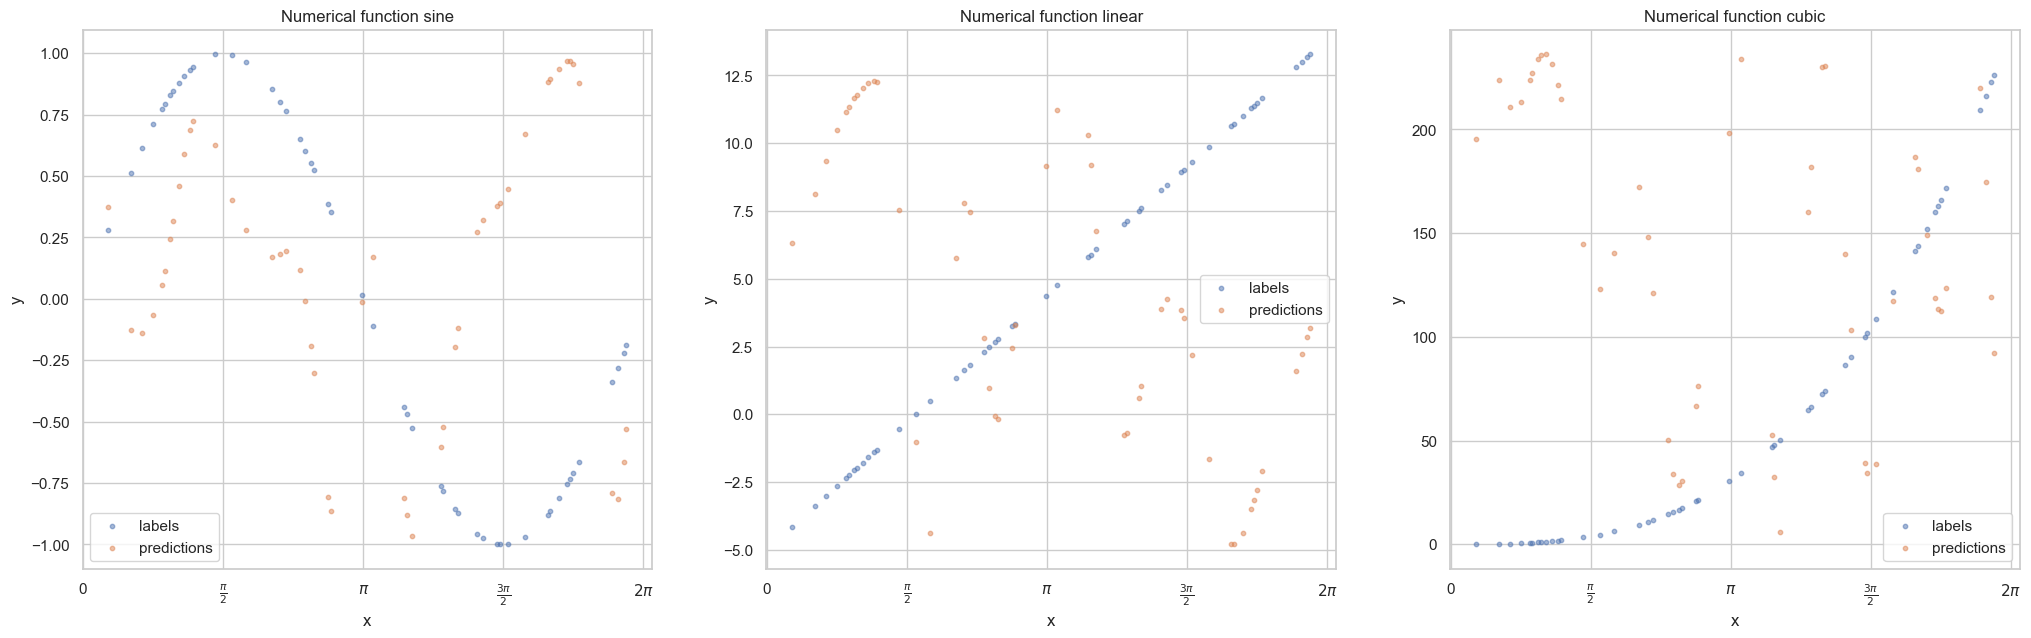

In [11]:
layers = [12, 12, 12]
inits = [[np.random.randn(n_layers, 3, requires_grad=True), np.array(0.0, requires_grad=True)] for n_layers in layers]
eval(inits)

The function variational_circuit is evaluated using the initial parameters for each numerical function. 

Generally, the predictions are quite inaccurate. 

This is because the initial parameters are generated randomly, rather than through a machine learning workflow, leading to inconsistent predictions from the function variational_circuit.

Finally, we are set to begin the optimization process. 

We will store the optimized parameters for each numerical function in their respective optimizer lists, allowing us to use them during the evaluation.

In [12]:
adam_optimized_params = []
sizes_steps = [0.05] * 3
names=["sine","linear","cubic"]
for i in range(len(names)):
    print(names[i])
    Adam_optimizer = AdamOptimizer(sizes_steps[i])
    adam_params = train(inits[i],Xs_train[i],Ys_train[i],Xs_test[i],Ys_test[i],Adam_optimizer,opt_itrs=100)
    adam_optimized_params.append(adam_params)

sine
Iteration:    1 | train_RMSE: 0.6633360 | test_RMSE: 0.7725895
Iteration:    2 | train_RMSE: 0.5456257 | test_RMSE: 0.6328016
Iteration:    3 | train_RMSE: 0.4475038 | test_RMSE: 0.4774394
Iteration:    4 | train_RMSE: 0.3870546 | test_RMSE: 0.3608876
Iteration:    5 | train_RMSE: 0.3664611 | test_RMSE: 0.3200911
Iteration:    6 | train_RMSE: 0.3255701 | test_RMSE: 0.2813783
Iteration:    7 | train_RMSE: 0.2835292 | test_RMSE: 0.2597984
Iteration:    8 | train_RMSE: 0.2699916 | test_RMSE: 0.2696360
Iteration:    9 | train_RMSE: 0.2500634 | test_RMSE: 0.2659221
Iteration:   10 | train_RMSE: 0.2185796 | test_RMSE: 0.2500102
Iteration:   11 | train_RMSE: 0.1954993 | test_RMSE: 0.2412900
Iteration:   12 | train_RMSE: 0.1810681 | test_RMSE: 0.2329270
Iteration:   13 | train_RMSE: 0.1683804 | test_RMSE: 0.2148261
Iteration:   14 | train_RMSE: 0.1595064 | test_RMSE: 0.1928401
Iteration:   15 | train_RMSE: 0.1516503 | test_RMSE: 0.1725530
Iteration:   16 | train_RMSE: 0.1424773 | test_RMS

### Evaluation

We evaluate the performance of Adam's optimization on numerical functions and plot the cost history.

Normalized RMSE for function sine :  0.019090335709887676
Normalized RMSE for function linear :  0.06167062328247008
Normalized RMSE for function cubic :  0.05087159567652756


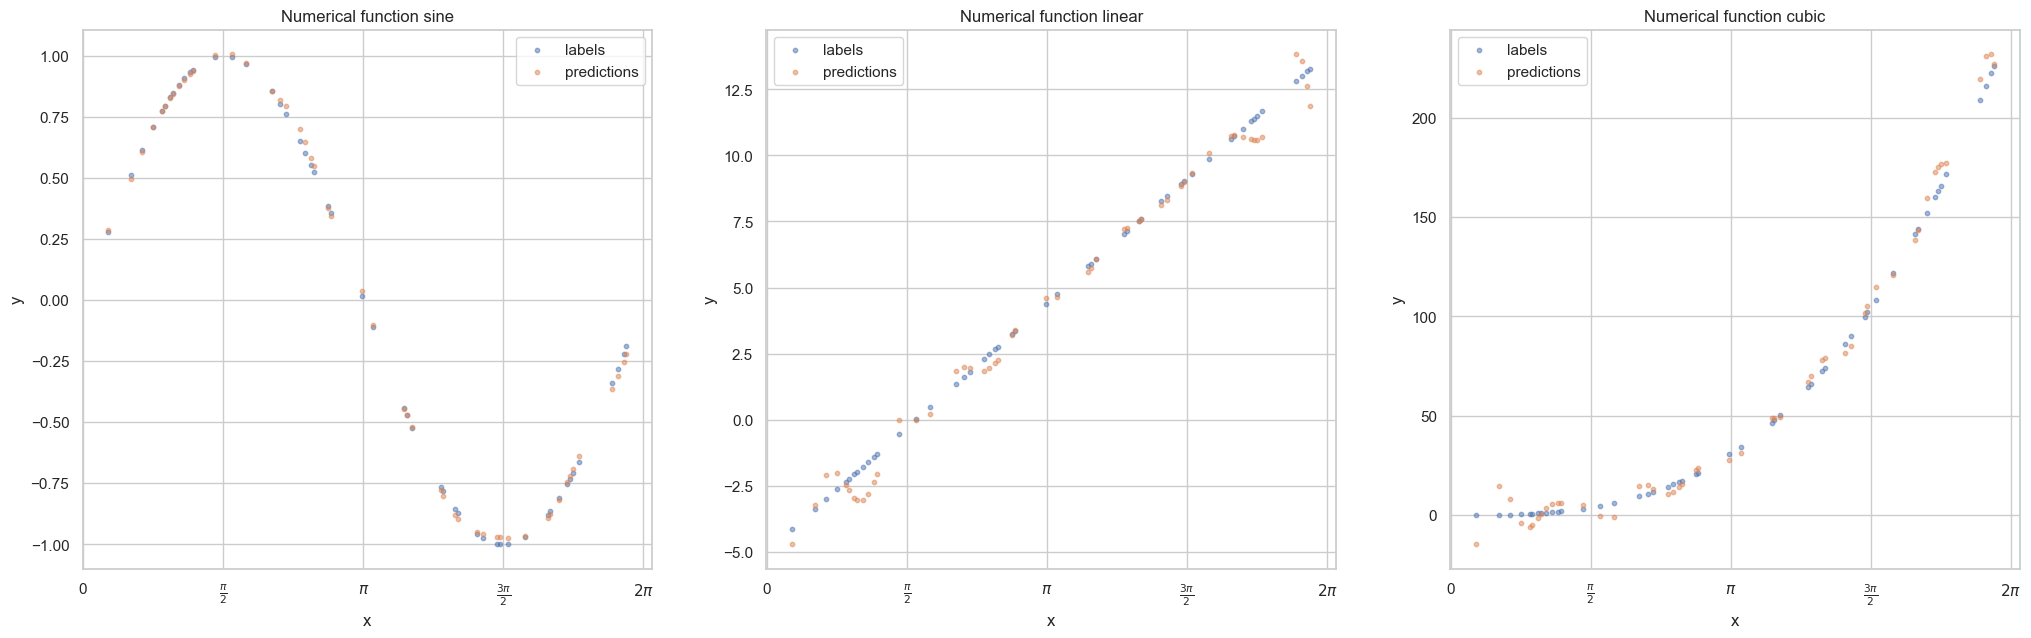

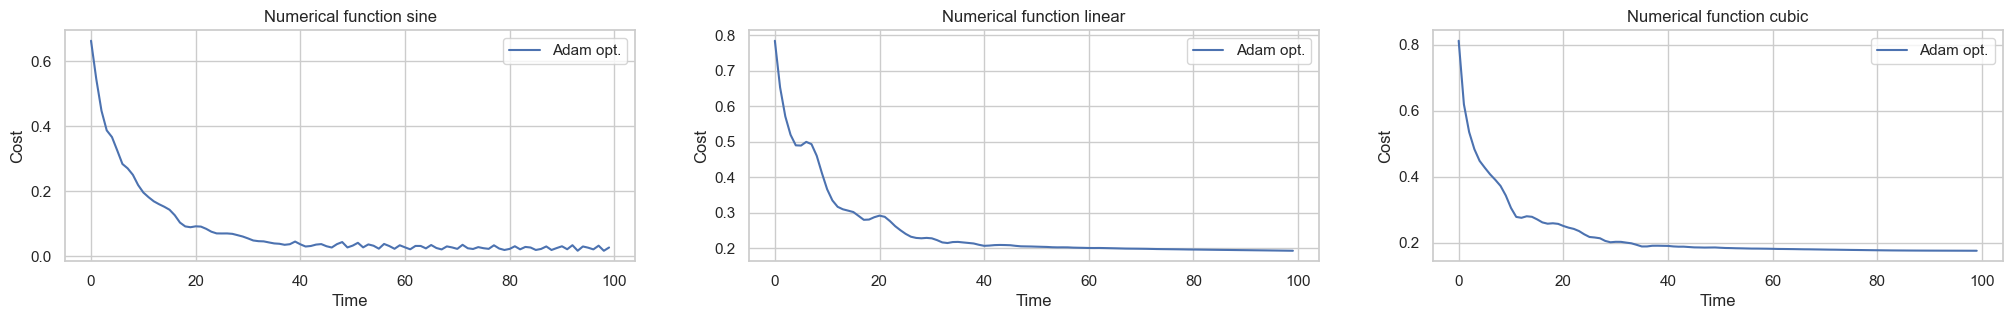

In [13]:
eval(adam_optimized_params)
history(adam_optimized_params)

### Conclusion

### References

https://c3.ai/glossary/data-science/root-mean-square-error-rmse/

https://docs.pennylane.ai/en/stable/code/api/pennylane.AdamOptimizer.html
